In [73]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.inspection import plot_partial_dependence
from sklearn import tree
from xgboost import XGBClassifier

## Import clean dataset 
#### This dataset is not standardized nor upsampled/dowsnampled but it is encoded using one hot encoding and it contains no NAs

In [2]:
# train = pd.read_csv('train_rus.csv')
# test = pd.read_csv('test_data.csv')

In [3]:
df = pd.read_csv('training_clean_and_complete.csv')

In [4]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,elective_surgery,icu_id,readmission_status,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,...,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
0,1,214826,118,0,92,0,0,0,0,0,...,36.9,36.1,557,487.0,4.2,3.8,145.0,145.0,23.3,12.7
1,2,246060,81,0,90,0,0,0,0,0,...,34.5,33.2,194,185.0,4.2,3.9,139.0,138.0,11.1,10.1
2,3,276985,118,0,93,0,0,0,0,0,...,34.0,25.9,198,43.0,5.0,3.5,139.0,138.0,9.0,8.0
3,4,262220,118,1,92,0,1,0,0,1,...,34.5,33.2,194,185.0,4.2,3.9,139.0,138.0,11.1,10.1
4,5,201746,33,0,91,0,0,0,0,0,...,44.2,44.2,159,159.0,3.9,3.7,137.0,137.0,10.9,10.9


In [5]:
# # Let's drop the first column
df = df.drop(df.columns[0], axis=1)

In [6]:
# # Let's move our target variable to the end of the df
col = df.pop("diabetes_mellitus")
df.insert(143, col.name, col)

In [7]:
# Remove features we don't need for modeling
# train.drop(['encounter_id', 'hospital_id', 'icu_id'], axis=1, inplace=True)
# test.drop(['encounter_id', 'hospital_id', 'icu_id'], axis=1, inplace=True)

In [8]:
df.head()

,encounter_id,hospital_id,elective_surgery,icu_id,readmission_status,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,...,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus
0,214826,118,0,92,0,0,0,0,0,0,...,36.1,557,487.0,4.2,3.8,145.0,145.0,23.3,12.7,1
1,246060,81,0,90,0,0,0,0,0,1,...,33.2,194,185.0,4.2,3.9,139.0,138.0,11.1,10.1,1
2,276985,118,0,93,0,0,0,0,0,0,...,25.9,198,43.0,5.0,3.5,139.0,138.0,9.0,8.0,0
3,262220,118,1,92,0,1,0,0,1,1,...,33.2,194,185.0,4.2,3.9,139.0,138.0,11.1,10.1,0
4,201746,33,0,91,0,0,0,0,0,0,...,44.2,159,159.0,3.9,3.7,137.0,137.0,10.9,10.9,0


In [9]:
# Chceck to make sure that the 60th column is the first numerical column -- it should be age
df.iloc[:, 60]

0         77
1         25
2         81
3         19
4         67
          ..
130151    50
130152    79
130153    73
130154    81
130155    35
Name: age, Length: 130156, dtype: int64

In [10]:
df.iloc[:, 143]

0         1
1         1
2         0
3         0
4         0
         ..
130151    0
130152    0
130153    0
130154    1
130155    0
Name: diabetes_mellitus, Length: 130156, dtype: int64

## Feature selection

In [11]:
# from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# The matrix is symmetric so we need to extractt upper triangle matrix without diagonal (k=1)
def get_relevant_pairs(df):
    corr_matrix = df.corr().abs()
    relevant_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    return relevant_pairs

relevant_pairs = get_relevant_pairs(df)

In [12]:
relevant_pairs[:30]

gender_F             gender_M                     0.998979
d1_diasbp_min        d1_diasbp_noninvasive_min    0.992417
d1_diasbp_max        d1_diasbp_noninvasive_max    0.991618
d1_sysbp_max         d1_sysbp_noninvasive_max     0.991314
d1_sysbp_min         d1_sysbp_noninvasive_min     0.990883
d1_mbp_min           d1_mbp_noninvasive_min       0.989712
h1_sysbp_max         h1_sysbp_noninvasive_max     0.976572
h1_mbp_min           h1_mbp_noninvasive_min       0.975784
d1_mbp_max           d1_mbp_noninvasive_max       0.974644
d1_creatinine_max    d1_creatinine_min            0.968596
h1_sysbp_min         h1_sysbp_noninvasive_min     0.968380
h1_diasbp_max        h1_diasbp_noninvasive_max    0.967552
d1_bun_max           d1_bun_min                   0.966868
h1_diasbp_min        h1_diasbp_noninvasive_min    0.964458
h1_mbp_max           h1_mbp_noninvasive_max       0.961695
d1_platelets_max     d1_platelets_min             0.961553
d1_hemaglobin_min    d1_hematocrit_min            0.9577

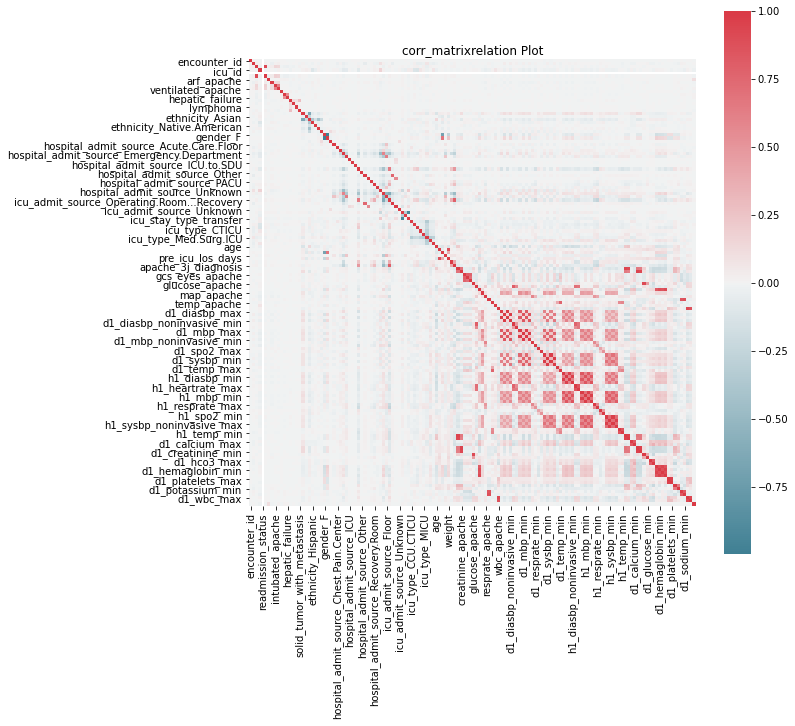

In [13]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
plt.title("corr_matrixrelation Plot")
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap = True), square=True, ax=ax)
plt.show()

In [14]:
# Normally one would remove highly correlated variables
# It makes sense for a lot of our variables to be related since we one-hot encoded them
# So we won't actually remove any variables but instead will rely on PCA/LDA for that

<ipython-input-15-b0402693afc7>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax)


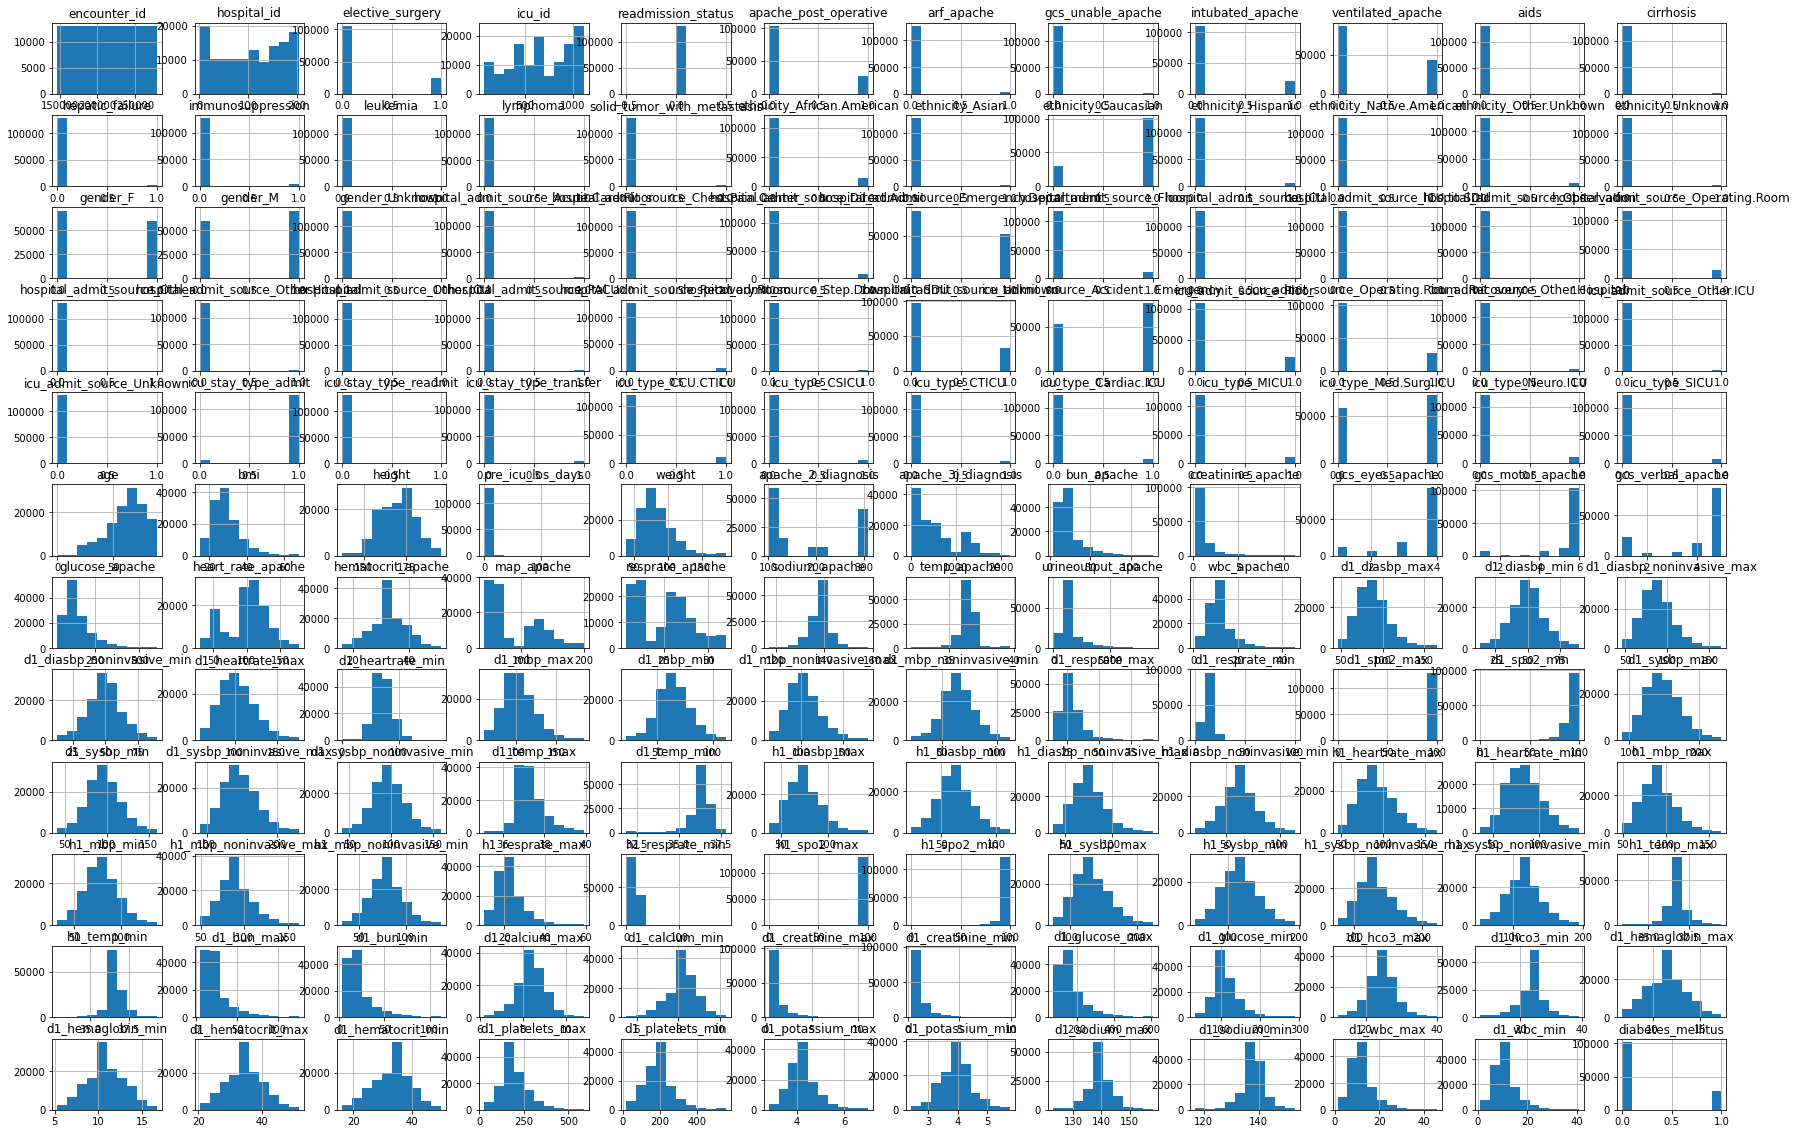

In [15]:
fig, ax = plt.subplots(figsize=(30,20))
df.hist(ax = ax)
plt.show()

In [16]:
# Some features are skewed but I will not standardize since a tree is not greatly affected by a standardization 
# and we want to interpret the tree splits in the original units.
# We're not going to apply PCA yet so we don't need to standardize

## Check distribution of target variable

In [17]:
# Check balance
target_count = df['diabetes_mellitus'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 102005
Class 1: 28151
Proportion: 3.62 : 1


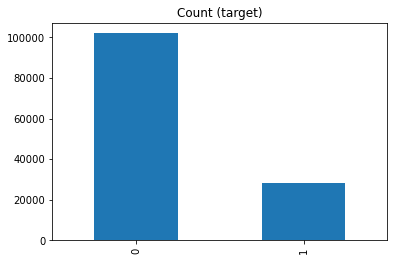

In [18]:
target_count.plot(kind='bar', title='Count (target)');

## Splitting Data

In [19]:
df.columns

Index(['encounter_id', 'hospital_id', 'elective_surgery', 'icu_id',
       'readmission_status', 'apache_post_operative', 'arf_apache',
       'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
       ...
       'd1_hematocrit_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'diabetes_mellitus'],
      dtype='object', length=144)

In [20]:
# Select random state for consistency
random_state = 42

In [21]:
# Drop columns we don't need for modeling
df_to_model = df.drop(['encounter_id', 'hospital_id', 'icu_id', 'readmission_status'], axis=1)

In [22]:
X = df_to_model.drop(['diabetes_mellitus'], axis = 1)
y = df_to_model['diabetes_mellitus']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = random_state)

## Get ready for modeling 
### Random Forest - better with noise, easier to tune
### Gradient Boosting - better for unbalanced data, harder to tune, not good with noise

In [25]:
start = timeit.default_timer()

rf_model = RandomForestClassifier(random_state = random_state)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=30, stop=100, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Class weight helps deal with imbalanced classes - can assign greater weight to minority classes
w_pos_range = [x for x in np.linspace(0.1, 0.6, num=10)]
class_weight = [{0:0.1, 1:w} for w in w_pos_range]

param_dist = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap,
             'class_weight': class_weight
             }

clf = RandomizedSearchCV(rf_model, param_dist, n_iter=5, n_jobs=-1, return_train_score=True, scoring='accuracy', random_state = random_state)
rf = clf.fit(X_train, y_train)

stop = timeit.default_timer()
print("Random forest grid search runtime: ", stop  - start )

Random forest grid search runtime:  217.33868039100003


In [26]:
rf.best_score_, rf.best_estimator_

(0.7839854323344524,
 RandomForestClassifier(class_weight={0: 0.1, 1: 0.2111111111111111},
                        max_depth=50, max_features='sqrt', min_samples_leaf=2,
                        min_samples_split=10, n_estimators=68, random_state=42))

In [27]:
rf_results = pd.DataFrame(rf.cv_results_).sort_values('mean_test_score', ascending  = False)
rf_results[['mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_min_samples_split', 
            'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'param_bootstrap']].head()

,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap
4,0.783985,0.995726,68,10,2,sqrt,50,True
1,0.783787,0.844690,30,10,2,sqrt,26,True
2,0.782212,0.999950,92,10,4,sqrt,38,False
3,0.761739,0.980991,61,2,2,sqrt,18,True
0,0.737168,0.980345,68,5,2,sqrt,22,True


              precision    recall  f1-score   support

           0       0.78      1.00      0.88     33542
           1       0.48      0.01      0.03      9410

    accuracy                           0.78     42952
   macro avg       0.63      0.51      0.45     42952
weighted avg       0.72      0.78      0.69     42952



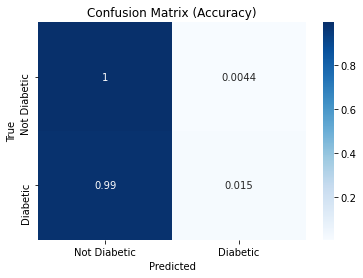

In [28]:
y_pred = rf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')

# Plot confusion matrix 
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Accuracy)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

In [29]:
# The high accuracy of the model is deceptive. It is performing well on the negative class but not on the diabetic class, which is what we care about.
# Let's adjust the threshold to value true postive rates more.

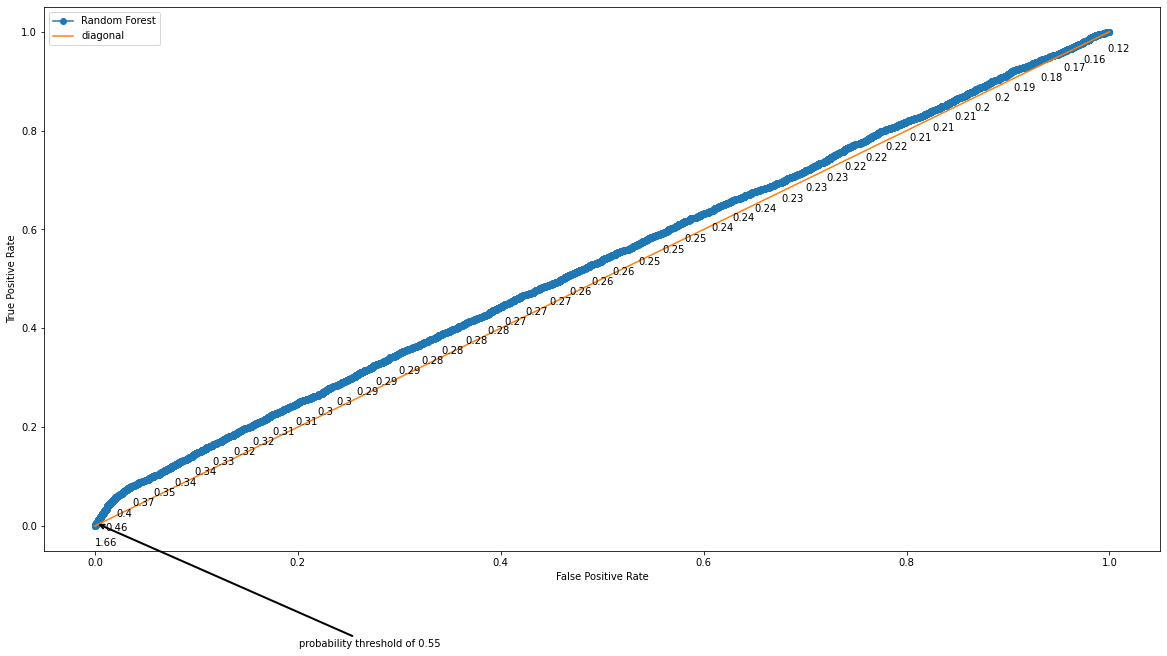

In [30]:
# ROC curve to get optimal threshold on validation set: https://stats.stackexchange.com/questions/389979/determine-thresholds-for-test-from-roc-curve
predicted_proba = rf.predict_proba(X_val)
rf_probs = predicted_proba[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(y_val, rf_probs)

plt.subplots(figsize=(20,10))
plt.plot(rf_fpr, rf_tpr, 'o-', label = "Random Forest")
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10), label="diagonal")

for x, y, txt in zip(rf_fpr[::150], rf_tpr[::150], thresholds[::150]):
    plt.annotate(np.round(txt, 2), (x, y - 0.04))
rnd_idx = 27
plt.annotate('probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)),
            xy=(rf_fpr[rnd_idx], rf_tpr[rnd_idx]), xytext = (rf_fpr[rnd_idx]+0.2, rf_tpr[rnd_idx]-0.25),
            arrowprops=dict(facecolor='black', lw=2, arrowstyle = '->'),)

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [33]:
# Retrieving optimal threshold
opt_threshold = thresholds[np.argmax(rf_tpr - rf_fpr)]
predicted_proba = rf.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     33542
           1       0.48      0.01      0.03      9410

    accuracy                           0.78     42952
   macro avg       0.63      0.51      0.45     42952
weighted avg       0.72      0.78      0.69     42952



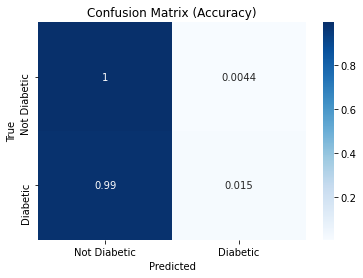

In [44]:
# Retrieving optimal threshold
opt_threshold = thresholds[np.argmax(rf_tpr - rf_fpr)]
predicted_proba = rf.best_estimator_.predict(X_test)
y_pred = (predicted_proba [:] >= opt_threshold).astype('int')
cm = confusion_matrix(y_test, y_pred, normalize = 'true')

# Plot confusion matrix 
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Accuracy)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

In [45]:
# We wnat to maximize true postiives and minimize false negatives. We care about recall - correctly capturing the maximum number of diabetic patients.
# (The con of maximizing recall is potentially diagnosing non-diabetic patients with diabetes. However, this loss is much less than mis-diagnosing someone with diabetes as not having diabetes.)
# So let's try metrics other than accuracy to try to improve predictions on the diabetic class (without completely sacrificing performance on the non-diabetic class.)

### Testing Non-Accuracy Metrics

In [48]:
def grid_search(model, param_dist, scoring):
    """
    Getting the model with the highest score (user-defined string) with randomized grid search.
    """
    clf = RandomizedSearchCV(model, param_dist, n_iter=5, cv=10, n_jobs = -1, return_train_score = True, scoring = scoring, random_state = random_state)
    fitted = clf.fit(X_train, y_train)
    return fitted

In [49]:
# Getting best recall model
fitted_recall = grid_search(rf_model, param_dist, 'recall')
fitted_recall.best_score_, fitted_recall.best_estimator_

(0.14544113877286366,
 RandomForestClassifier(class_weight={0: 0.1, 1: 0.4888888888888888},
                        max_depth=22, max_features='sqrt', min_samples_leaf=2,
                        min_samples_split=5, n_estimators=68, random_state=42))

In [50]:
rf_results = pd.DataFrame(fitted_recall.cv_results_).sort_values('mean_test_score', ascending= False)
rf_results[['mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_min_samples_split', 
            'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'param_bootstrap']].head()

,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap
0,0.145441,0.999322,68,5,2,sqrt,22,True
3,0.083676,0.952111,61,2,2,sqrt,18,True
2,0.045952,1.000000,92,10,4,sqrt,38,False
4,0.013331,0.979963,68,10,2,sqrt,50,True
1,0.008084,0.271467,30,10,2,sqrt,26,True


In [53]:
def cm_func(fitted):
    """
    Returns a confusion matrix and y_pred for the best model returend by grid_search(model, param_dist, scoring).
    """
    
    best_model = fitted.best_estimator_
    predicted_proba = best_model.predict_proba(X_test)
    
    probs = predicted_proba[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    opt_threshold = thresholds[np.argmax(tpr - fpr)]
    y_pred = (predicted_proba[:,1] >= opt_threshold).astype('int')
    
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    return cm, y_pred

              precision    recall  f1-score   support

           0       0.79      0.56      0.66     33542
           1       0.23      0.48      0.31      9410

    accuracy                           0.54     42952
   macro avg       0.51      0.52      0.49     42952
weighted avg       0.67      0.54      0.58     42952



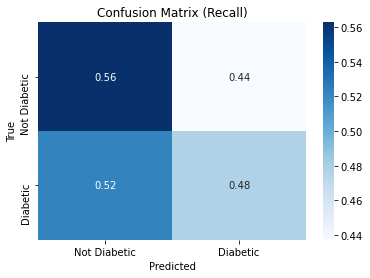

In [54]:
# Plot confusion matrix for best recall model
cm, y_pred = cm_func(fitted_recall)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Recall)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.45      0.57     33542
           1       0.23      0.61      0.34      9410

    accuracy                           0.48     42952
   macro avg       0.52      0.53      0.46     42952
weighted avg       0.68      0.48      0.52     42952



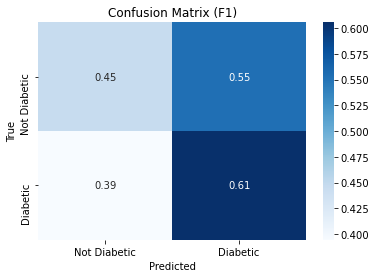

In [55]:
# Plot confusion matrix for best f1_weighted model
fitted_f = grid_search(rf_model, param_dist, 'f1_weighted')
cm, y_pred = cm_func(fitted_f)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (F1)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.56      0.66     33542
           1       0.23      0.48      0.31      9410

    accuracy                           0.54     42952
   macro avg       0.51      0.52      0.49     42952
weighted avg       0.67      0.54      0.58     42952



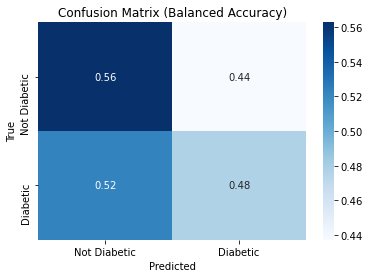

In [56]:
# Plot confusion matrix for best balanced accuracy model
fitted_ba = grid_search(rf_model, param_dist, 'balanced_accuracy')
cm, y_pred = cm_func(fitted_ba)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Balanced Accuracy)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.45      0.57     33542
           1       0.23      0.61      0.34      9410

    accuracy                           0.48     42952
   macro avg       0.52      0.53      0.46     42952
weighted avg       0.68      0.48      0.52     42952



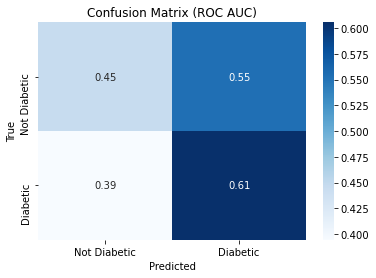

In [58]:
# Plot confusion matrix for best balanced accuracy model
fitted_roc_auc = grid_search(rf_model, param_dist, 'roc_auc')
cm, y_pred = cm_func(fitted_roc_auc)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (ROC AUC)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# classification report
print(classification_report(y_test, y_pred))

In [59]:
# Has diabetes/not diabetic percentages in predicted y 
y = np.bincount(y_pred)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

array([[    0, 18670],
       [    1, 24282]])

In [60]:
feature_importances = pd.DataFrame(fitted_recall.best_estimator_.feature_importances_, index = X_train.columns,
                                  columns = ['importance']).sort_values('importance', ascending = False)
feature_importances

,importance
arf_apache,0.017744
urineoutput_apache,0.016276
bmi,0.016260
weight,0.016143
pre_icu_los_days,0.015998
...,...
hospital_admit_source_Other.ICU,0.000018
hospital_admit_source_ICU,0.000000
hospital_admit_source_ICU.to.SDU,0.000000
hospital_admit_source_Observation,0.000000


In [71]:
feature_importances[: 20]

,importance
arf_apache,0.017744
urineoutput_apache,0.016276
bmi,0.016260
weight,0.016143
pre_icu_los_days,0.015998
d1_glucose_max,0.014796
age,0.014502
d1_glucose_min,0.014487
d1_platelets_max,0.013980
glucose_apache,0.013910


In [61]:
# We can see that arf_apache and urineout_apache and bmi are the most important predictors for diabetes

In [64]:
clf_tree = fitted_recall.best_estimator_.estimators_[0]

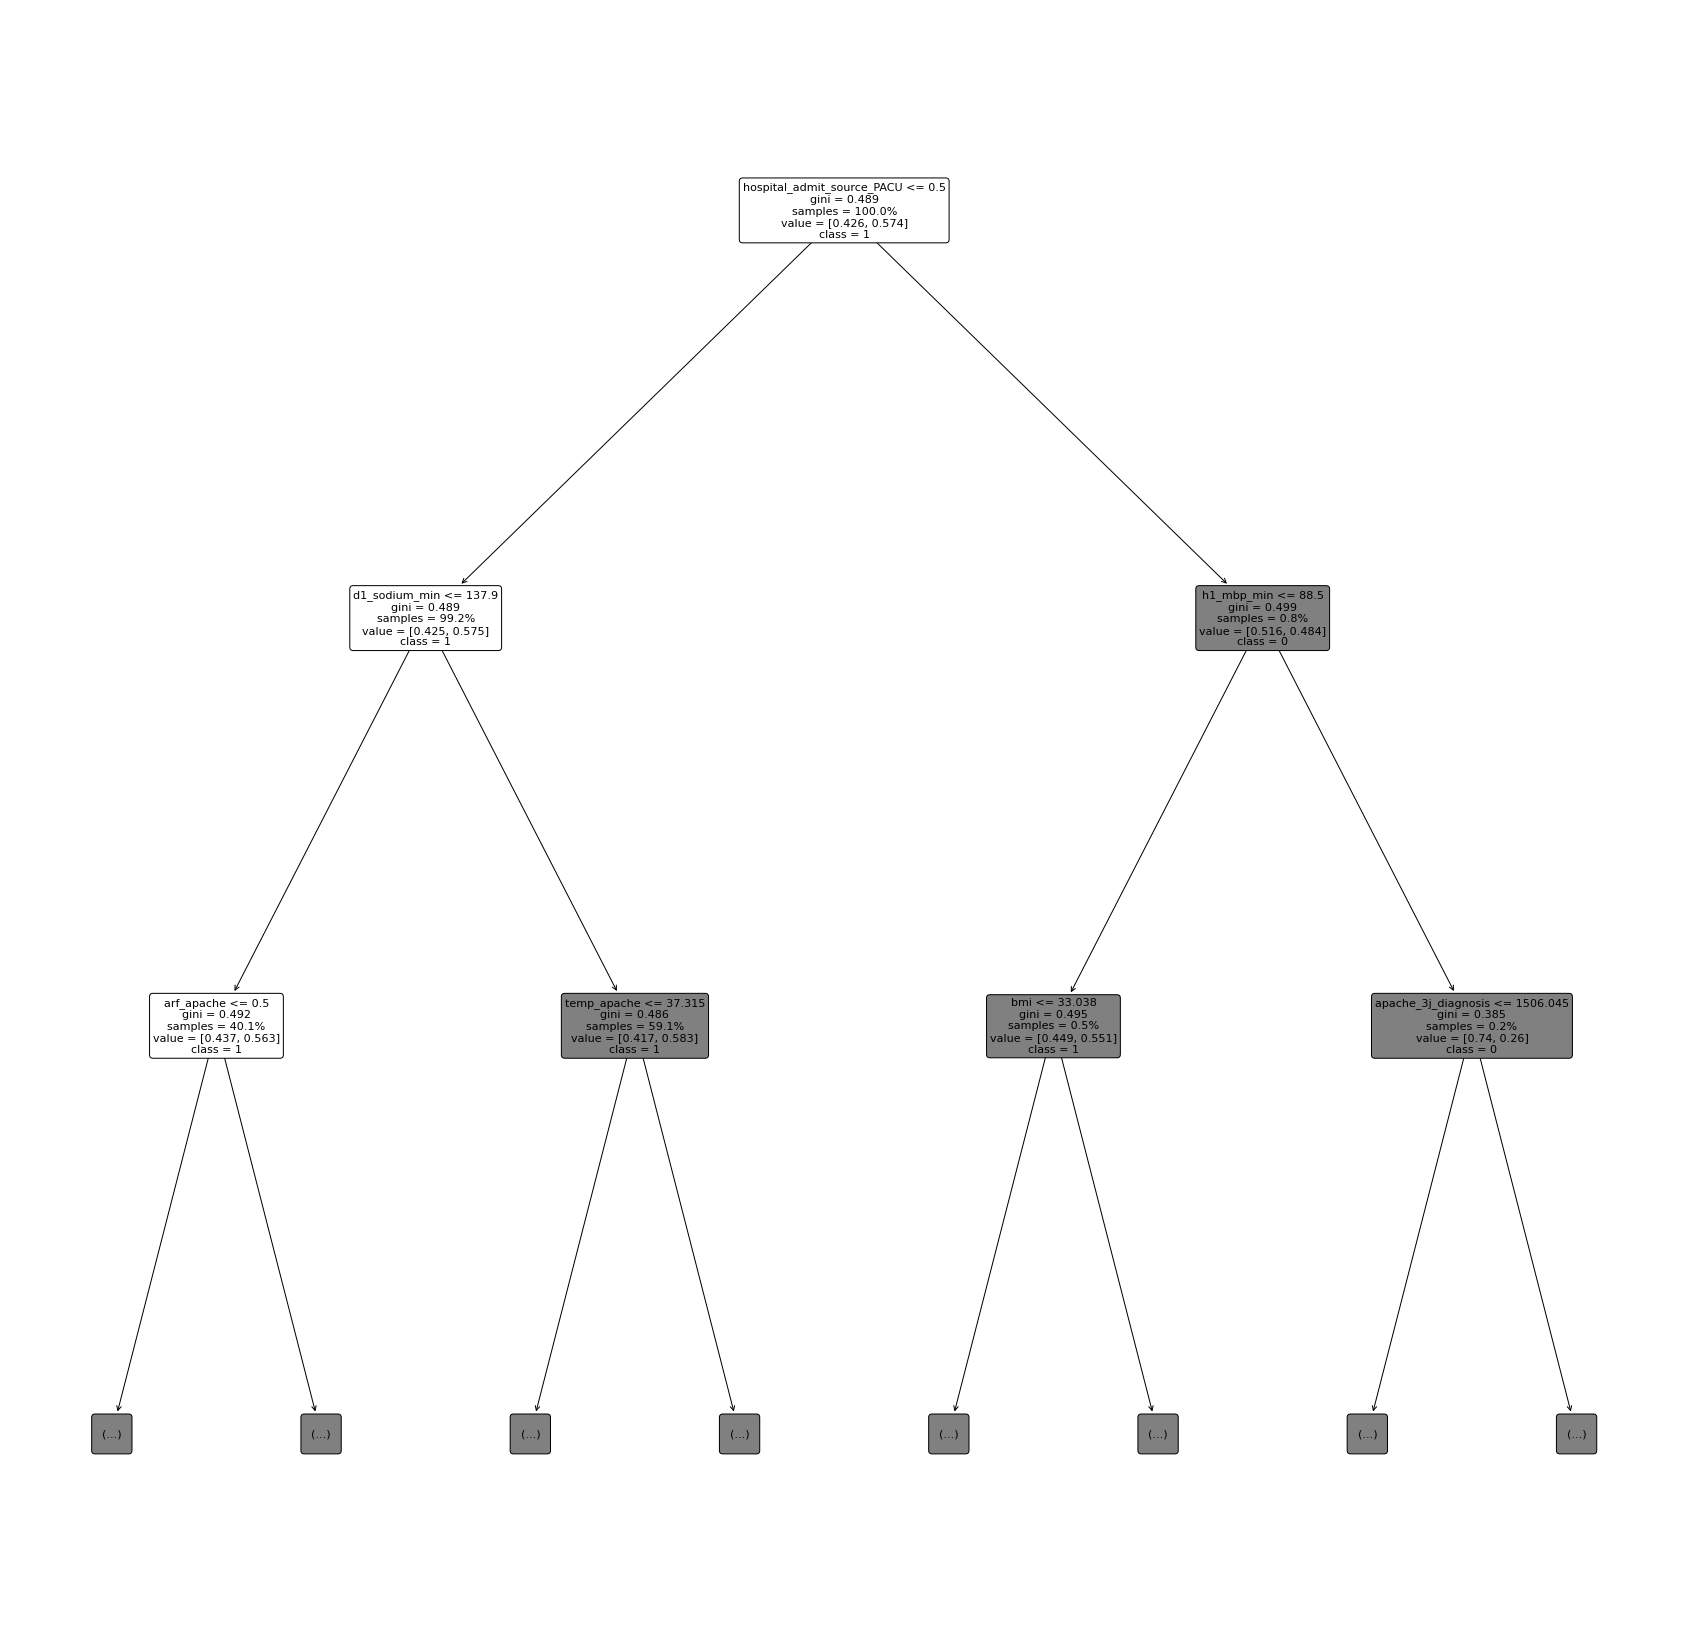

In [66]:
fig, ax = plt.subplots(figsize = (30,30))
tree.plot_tree(clf_tree, max_depth = 2, feature_names = X_train.columns, class_names = ['0', '1'], rounded = True,
              proportion = True)
plt.show()

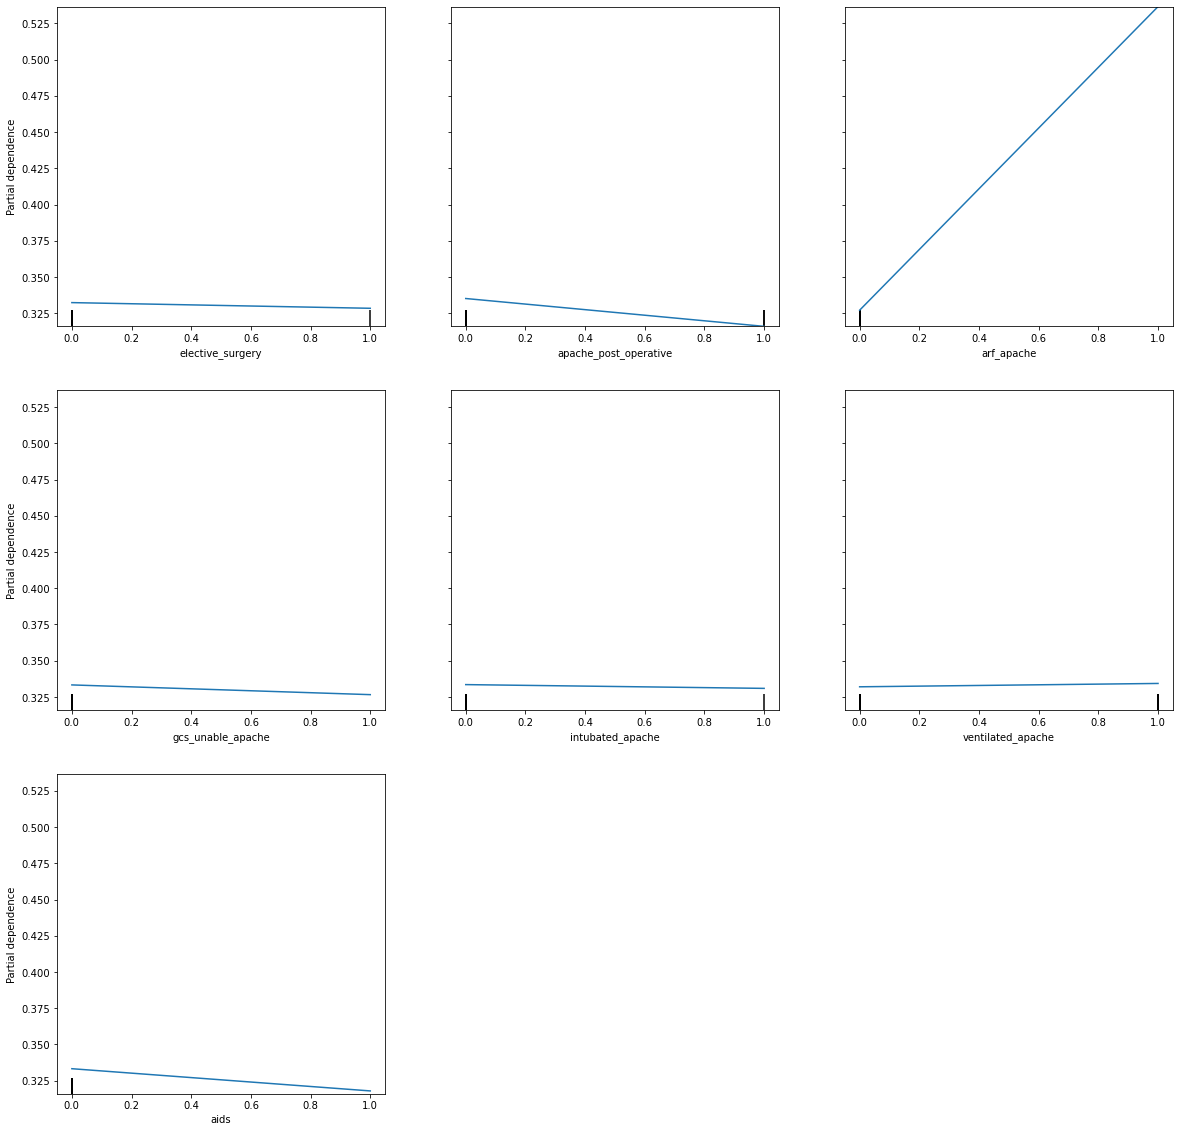

In [70]:
# Single partial dependence plots for top 7 features
fig, ax = plt.subplots(figsize = (20,20))
features = [x for x in range(7)]
single_dep = plot_partial_dependence(fitted_ba, X_train, features, ax=ax)

In [ ]:
# Looking for interaction effects
fig, ax = plt.subplots(figsize = (20,20))
features = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (1,2), (1,3), (1,4), (1,6)]
double_dep = plot_partial_dependence(fitted_ba, X_train, features, ax = ax)

## Gradient Boosting

In [74]:
# Increasing scale_pos_weight puts greater penalty on incorrect classifications in minority class (ppl with diabetes)
gb_model = XGBClassifier(scale_pos_weight = 3, random_state = random_state)
fitted = gb_model.fit(X_train, y_train)
print(fitted.get_xgb_params())

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 4, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


              precision    recall  f1-score   support

           0       0.79      0.81      0.80     33542
           1       0.26      0.23      0.25      9410

    accuracy                           0.69     42952
   macro avg       0.53      0.52      0.52     42952
weighted avg       0.67      0.69      0.68     42952



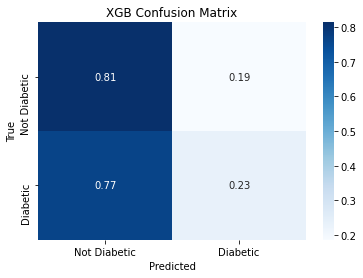

In [77]:
# Plot confusion matrix
y_pred = gb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = "Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('XGB Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Diabetic', "Diabetic"])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# Classification report
print(classification_report(y_test, y_pred))

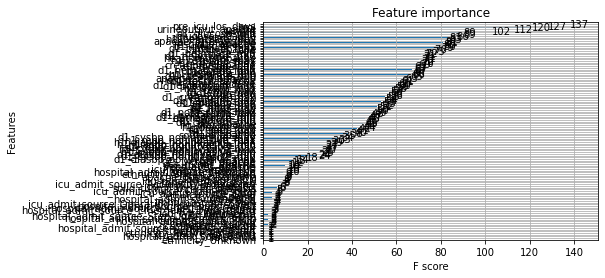

In [86]:
from xgboost import plot_importance
plot_importance(fitted)
plt.show()

In [87]:
# Grid search
start = timeit.default_timer()

gb_model = XGBClassifier(random_state = random_state)

max_depth = [int(x) for x in np.linspace(2, 50, num=11)]
learning_rate = [x for x in np.linspace(0, 0.6, num=20)]
booster = ['gbtree']
scale_pos_weight = [int(x) for x in np.linspace(1, 10, 11)]
reg_alpha = [x for x in np.linspace(0, 1, num=15)]
reg_lambda = [x for x in np.linspace(0, 1, num=15)]

# tree method : 'exact' for larger datasets
param_dist_2 = {'max_depth': max_depth,
                'learning_rate': learning_rate,
                'booster' : booster,
                'scale_pos_weight': scale_pos_weight,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda}

clf_2 = RandomizedSearchCV(gb_model, param_dist_2, n_iter =5, cv=10, n_jobs = -1, 
                           return_train_score = True, scoring = 'accuracy')
gb = clf_2.fit(X_train, y_train)

stop = timeit.default_timer()
print('XGB grid search runtime: ', stop -  start)

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB grid search runtime:  6501.105480066999


In [88]:
gb.best_score_, gb.best_estimator_

(0.7839548961221784,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.15789473684210525, max_delta_step=0, max_depth=40,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
               reg_alpha=0.9285714285714285, reg_lambda=0.5, scale_pos_weight=1,
               subsample=1, tree_method='exact', validate_parameters=1,
               verbosity=None))

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.57      0.66     33542
           1       0.24      0.48      0.32      9410

    accuracy                           0.55     42952
   macro avg       0.52      0.52      0.49     42952
weighted avg       0.67      0.55      0.59     42952



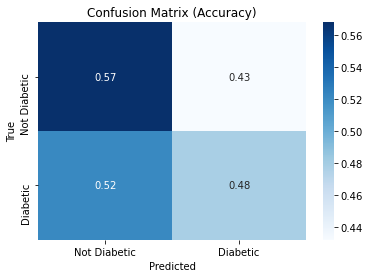

In [89]:
# Plot confusion matrix for best accuracy model
fitted_acc = grid_search(gb_model, param_dist_2, 'accuracy')
cm, y_pred = cm_func(fitted_acc)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Accuracy)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# Classification report
print(classification_report(y_test, y_pred))

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:34:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     33542
           1       0.26      0.28      0.27      9410

    accuracy                           0.66     42952
   macro avg       0.52      0.53      0.52     42952
weighted avg       0.67      0.66      0.67     42952



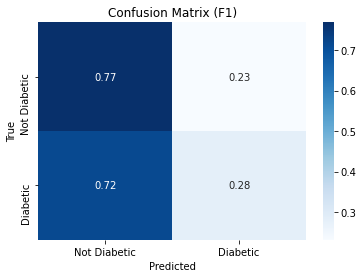

In [90]:
# Plot confusion matrix for f1_weighted model
fitted_f1 = grid_search(gb_model, param_dist_2, 'f1_weighted')
cm, y_pred = cm_func(fitted_f1)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (F1)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# Classification report
print(classification_report(y_test, y_pred))

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.60      0.68     33542
           1       0.25      0.47      0.32      9410

    accuracy                           0.57     42952
   macro avg       0.52      0.53      0.50     42952
weighted avg       0.68      0.57      0.61     42952



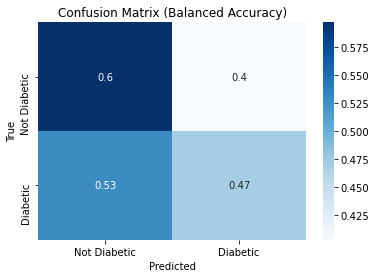

In [91]:
# Plot confusion matrix for best_balanced_accuracy model
fitted_ba = grid_search(gb_model, param_dist_2, 'balanced_accuracy')
cm, y_pred = cm_func(fitted_ba)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Balanced Accuracy)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# Classification report
print(classification_report(y_test, y_pred))

/Users/preeyamody/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:19:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.60      0.68     33542
           1       0.25      0.47      0.32      9410

    accuracy                           0.57     42952
   macro avg       0.52      0.53      0.50     42952
weighted avg       0.68      0.57      0.61     42952



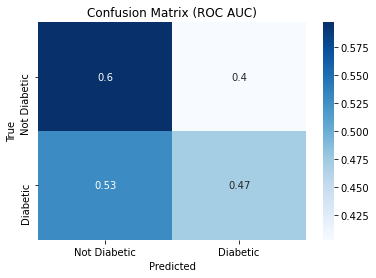

In [92]:
# Plot confusion matrix for best_roc_auc model
fitted_roc_auc = grid_search(gb_model, param_dist_2, 'roc_auc')
cm, y_pred = cm_func(fitted_roc_auc)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (ROC AUC)')
ax.xaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])
ax.yaxis.set_ticklabels(['Not Diabetic', 'Diabetic'])

# Classification report
print(classification_report(y_test, y_pred))

In [102]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [104]:
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.534
